### Pegando pontos de interesse da mascara

In [3]:
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import random

### Visualização dos Patches

In [4]:
def visualize_patch_centers(image, centers, patch_size):
    fig, ax = plt.subplots(1)
    
    image_np = np.array(image)
    
    if image_np.max() > 1:
        image_np = image_np / 255.0
    
    ax.imshow(image_np)
    
    patch_height, patch_width = patch_size
    
    for (h, w) in centers:
        rect = patches.Rectangle(
            (w - patch_width // 2, h - patch_height // 2), 
            patch_width, patch_height,
            linewidth=1, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        plt.plot(w, h, marker='v', color='r')
    
    ax.set_xlim([0, image_np.shape[1]])
    ax.set_ylim([image_np.shape[0], 0])
    
    plt.show()

In [5]:
def listar_imagens(diretorio_raiz, extensoes_imagens=None):
    if extensoes_imagens is None:
        extensoes_imagens = ['.jpg', '.jpeg', '.png']

    arquivos_imagens = []
    for dirpath, _, filenames in os.walk(diretorio_raiz):
        for filename in filenames:
            if any(filename.lower().endswith(extensao) for extensao in extensoes_imagens):
                caminho_completo = os.path.join(dirpath, filename)
                arquivos_imagens.append(caminho_completo)
    return arquivos_imagens
  
def exibir_imagens(lista_de_caminhos, largura=40, altura=25, path=True):
    num_imagens = len(lista_de_caminhos)
    
    if path:
    
      fig, axes = plt.subplots(1, num_imagens, figsize=(largura, altura))
    
      for i, caminho in enumerate(lista_de_caminhos):

          imagem = Image.open(caminho)
            
          axes[i].imshow(imagem)
          axes[i].axis('off')
          img = caminho.split("/")
          img = img[len(img)-1].replace("\\", " ").replace(".png", "")
          if "for" in img:
            img = img.replace("for intraepithelial lesion", "")
          axes[i].set_title(img)
      plt.show()
    else:
      
      fig, axes = plt.subplots(nrows=len(lista_de_caminhos), ncols=3, figsize=(largura, altura))
      plt.subplots_adjust(wspace=0.2)
      
      for i, each in enumerate(lista_de_caminhos):

          
          
          axes[i, 1].imshow(each["img-seg"])
          axes[i, 1].axis('off')
          if "for" in each["title"]:
            axes[i, 1].set_title(f'Segmentada  - {each["title"].replace("for intraepithelial lesion", "")}')
          else:
            axes[i, 1].set_title(f'Segmentada  - {each["title"]}')
              
          
          axes[i, 0].imshow(each["img"])
          axes[i, 0].axis('off')
          
          if "for" in each["title"]:
            
            axes[i, 0].set_title(f'Original - {each["title"].replace("for intraepithelial lesion", "")}')
          else:
            axes[i, 0].set_title(f'Original - {each["title"]}')
          
          axes[i, 2].imshow(each["img-mask"])
          axes[i, 2].axis('off')
          if "for" in each["title"]:
            axes[i, 2].set_title(f'Mask - {each["title"].replace("for intraepithelial lesion", "")}')
          else:
            axes[i, 2].set_title(f'Mask - {each["title"]}')
            
      plt.show()

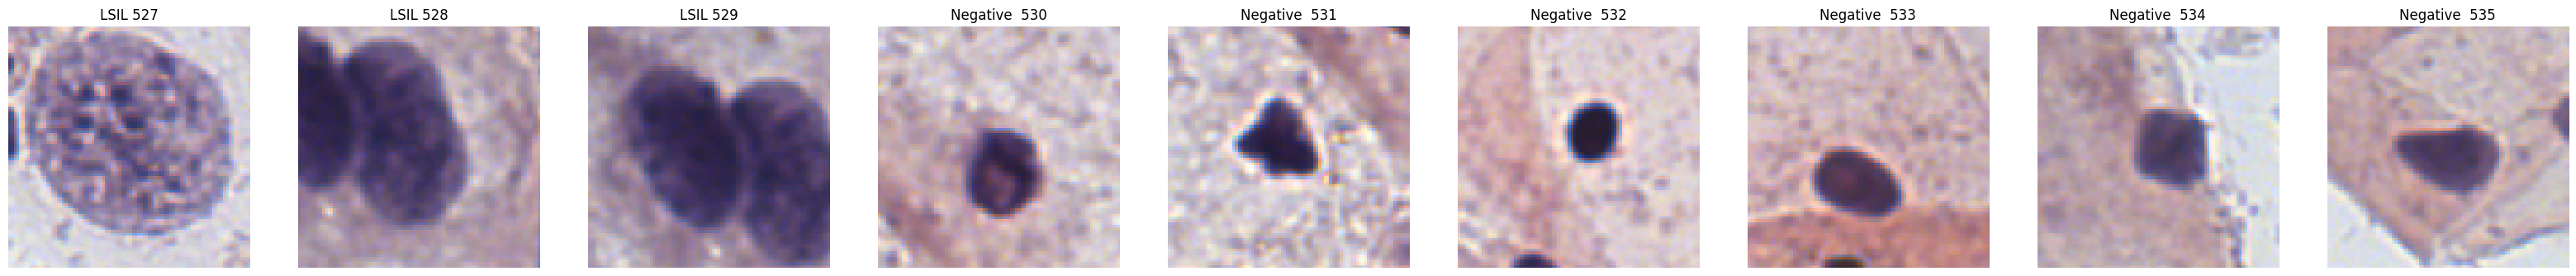

In [6]:
directory_path = '../../data/base_recortada/'
images = listar_imagens(directory_path)
exibir_imagens(images)

### Segmentação com Grabcut

In [6]:
def remover_fundo_com_grabcut_recortado(imagem):
    mascara = np.zeros(imagem.shape[:2], np.uint8)
    backgroundModel = np.zeros((1, 65), np.float64)
    foregroundModel = np.zeros((1, 65), np.float64)
    altura, largura = imagem.shape[:2]
    
    x1 = 0
    y1 = 0
    x2 = largura - 1
    y2 = altura - 1
        
    rectangle = (x1, y1, x2 - x1, y2 - y1)
    
    cv2.grabCut(imagem, mascara, rectangle,  
            backgroundModel, foregroundModel,
            3, cv2.GC_INIT_WITH_RECT)
    
    mascara_objeto = np.where((mascara == 2) | (mascara == 0), 0, 1).astype('uint8')
    
    imagem_sem_fundo = imagem * mascara_objeto[:, :, np.newaxis]
    
    img_recortada = imagem_sem_fundo[y1:y2, x1:x2]
    
    imagem_gray = cv2.cvtColor(img_recortada, cv2.COLOR_BGR2GRAY)
    
    _, mascara = cv2.threshold(imagem_gray, 10, 255, cv2.THRESH_BINARY)
    
    img_original_recortada = imagem[y1:y2, x1:x2]
    
    return img_recortada, mascara, img_original_recortada

In [7]:
def plot(resultados):
  num_cols = 3
  num_images = len(resultados)
  num_rows = (num_images + num_cols - 1) // num_cols 

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

  for i, img in enumerate(resultados):
      row = i // num_cols
      col = i % num_cols
      img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      axes[row, col].imshow(img_rgb)
      axes[row, col].axis('off') 

  for j in range(num_images, num_rows * num_cols):
      fig.delaxes(axes.flat[j])

  plt.tight_layout()
  plt.show()

In [ ]:
imagens_path = listar_imagens("../../data/base_recortada/")
lista_resultado = []

for path_img in imagens_path:
  imagem = cv2.imread(path_img)
  img_recortada, mask, img_original_recortada = remover_fundo_com_grabcut_recortado(imagem=imagem)
  lista_resultado.append(img_recortada)
  lista_resultado.append(mask)
  lista_resultado.append(img_original_recortada)
  


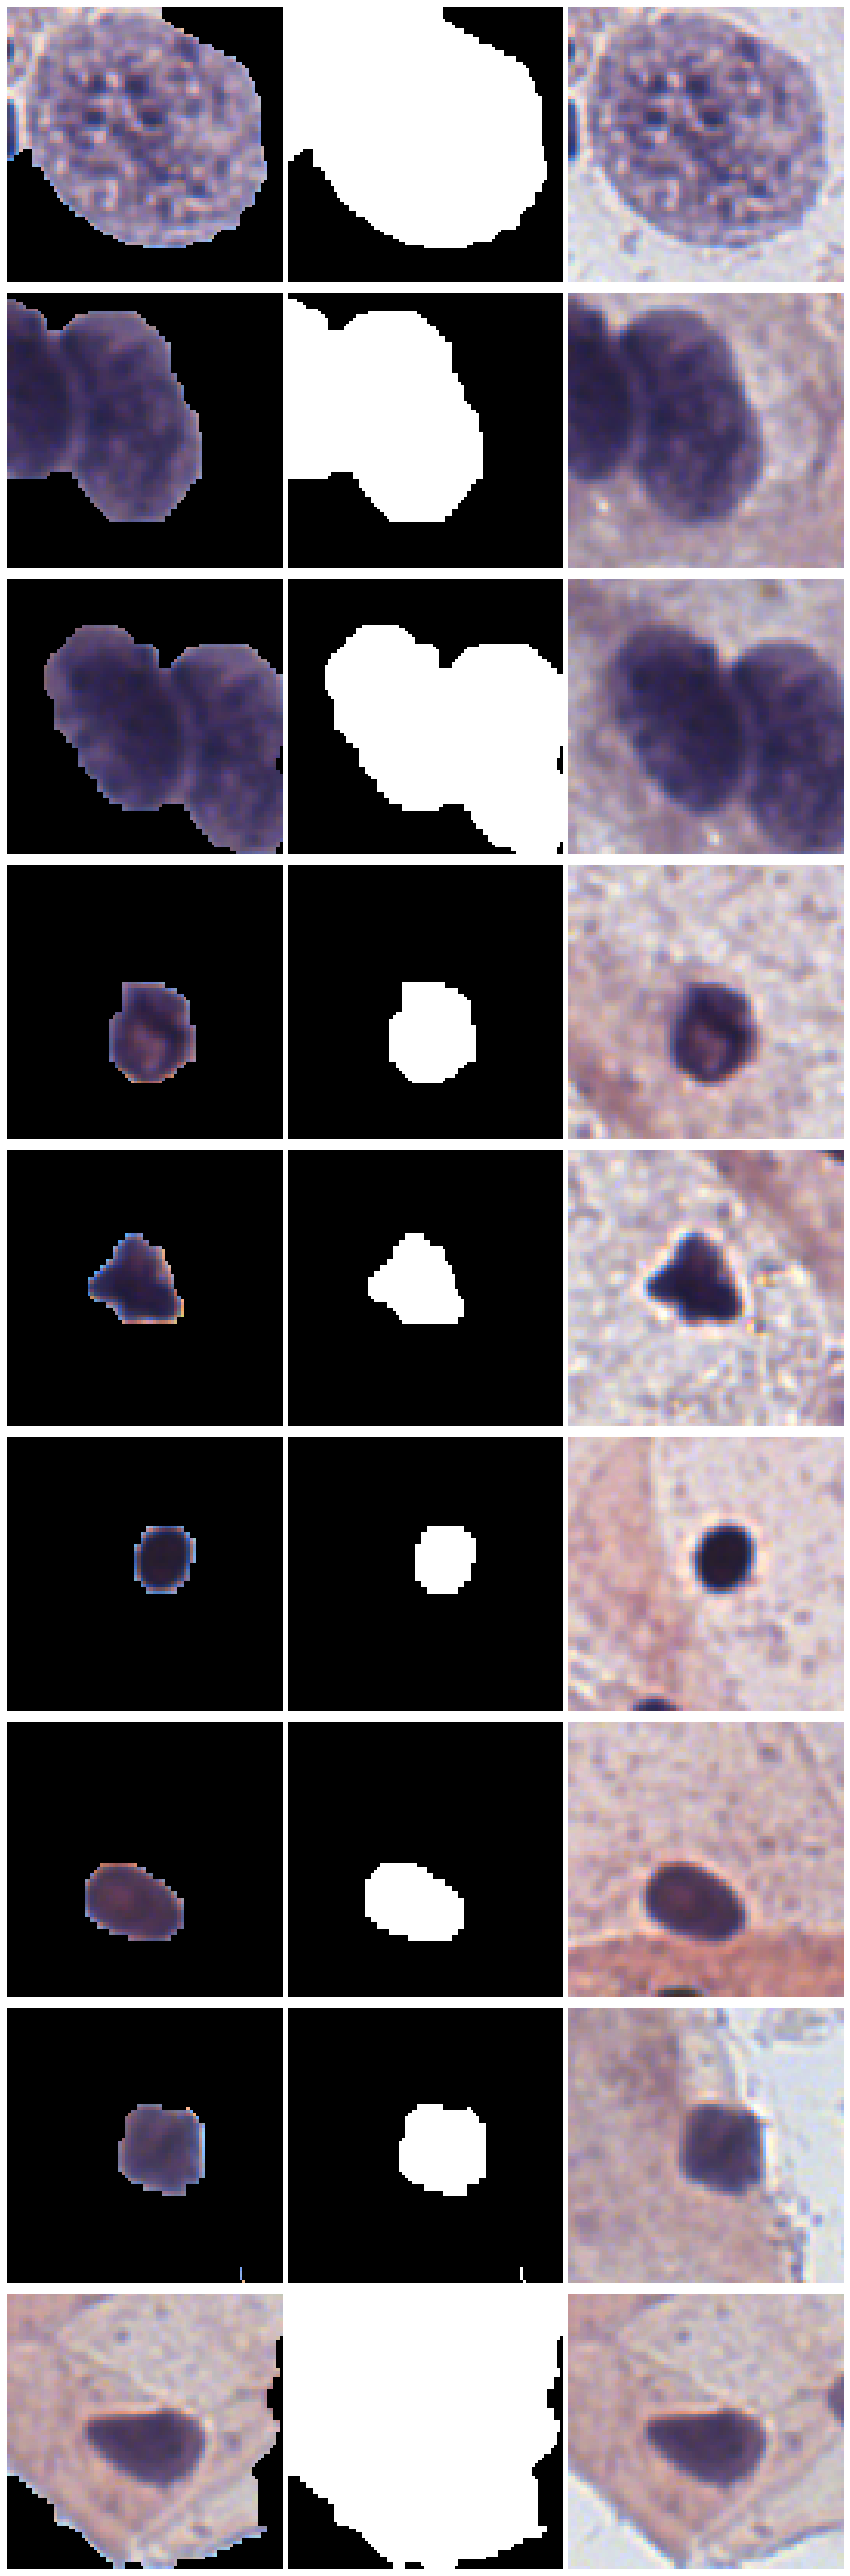

In [10]:
plot(lista_resultado)

### Definir Patches da areas de interesse

In [57]:
len(lista_resultado)

27

In [58]:
dict_img = {
  "img_com_mascara" : None,
  "mask" : None,
  "img_original": None,
}

array_dict_img = []

for item in range(0, 26, 3):
   dict_img["img_com_mascara"] = cv2.cvtColor(lista_resultado[item], cv2.COLOR_BGR2RGB)
   dict_img["mask"] = cv2.cvtColor(lista_resultado[item+1], cv2.COLOR_BGR2RGB)
   dict_img["img_original"] = cv2.cvtColor(lista_resultado[item+2], cv2.COLOR_BGR2RGB)
   array_dict_img.append(dict_img.copy())

In [59]:
len(array_dict_img)

9

(224, 224, 3)


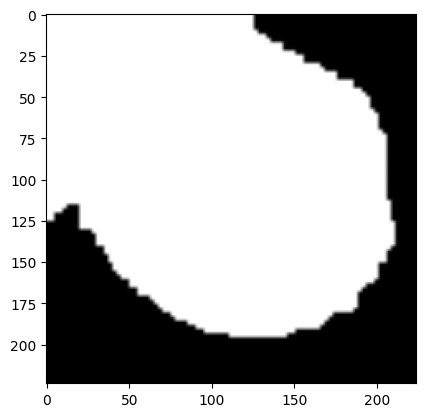

(224, 224, 3)


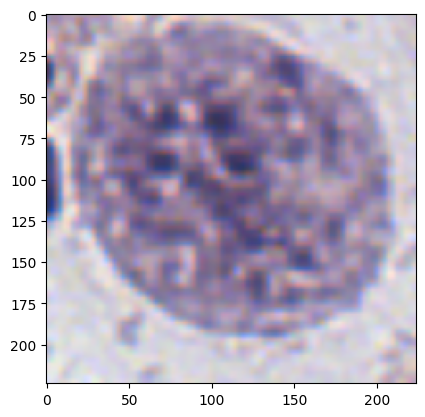

In [247]:
mask_test = array_dict_img[0]["mask"]
mask_test = cv2.resize(mask_test, (224, 224))
imagem_original = array_dict_img[0]["img_original"]
imagem_original = cv2.resize(imagem_original, (224, 224))

print(mask_test.shape)
plt.imshow(mask_test)
plt.show()
print(imagem_original.shape)
plt.imshow(imagem_original)
plt.show()

In [248]:
centers = []
altura, largura, _ = mask_test.shape

for i in range(altura):  
    for j in range(largura):
        pixel = mask_test[i, j]
        
        if len(pixel.shape) == 0:
            if pixel == 255:  
                  centers.append((i, j))
        else:  
            if np.array_equal(pixel, [255, 255, 255]): 
                  centers.append((i, j))

In [249]:
qtd_patches = int((224/16) * (224/16))
qtd_patches

196

In [250]:
len(centers)

32296

In [251]:
random.shuffle(centers)

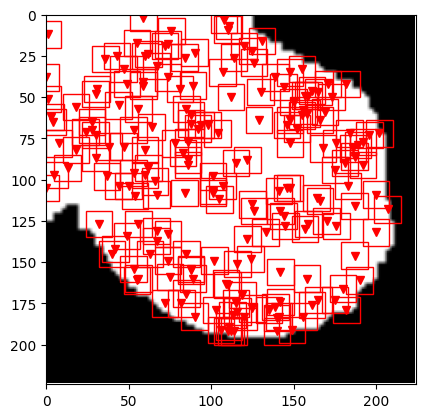

In [252]:
visualize_patch_centers(mask_test, centers[0:195], (16, 16))

### Algoritmo final da Extração de Patch por Mask

Algoritmo de patchs padrão

In [8]:
def generate_patch_centers(image_height, image_width, patch_size):
  
  stride = patch_size  
  
  num_patches_h = image_height // stride
  num_patches_w = image_width // stride
  
  centers_h = []
  centers_w = []
  
  for i in range(num_patches_h):
    centers_h.append((i * stride + stride // 2))
  
  for j in range(num_patches_w):
    centers_w.append((j * stride + stride // 2))
  
  centers = []

  for h in centers_h:
    for w in centers_w:
      centers.append((h,w))
  
  return centers

Funcao para verificar se a mascara veio defeituosa

In [9]:
def is_image_black_percentage(image, threshold=0.9):
    total_pixels = image.size
    
    if image.ndim == 2:
        black_pixels = np.sum(image == 0)
    elif image.ndim == 3: 
        black_pixels = np.sum(np.all(image == 0, axis=-1))

    black_percentage = black_pixels / total_pixels
    return black_percentage >= threshold

Remoção de Patches por segmentacao

In [11]:
def grabcutextractcenters(path_img, tamanho_img=(224, 224), stride=16):
  
  
  qtd_patches = int((tamanho_img[0]/stride) * (tamanho_img[0]/stride))
  
  print(f"Quantidade de patches da imagem: {qtd_patches}")
  
  imagem = cv2.imread(path_img)
  
  imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
  
  
  img_recortada, mask, img_original_recortada = remover_fundo_com_grabcut_recortado(imagem=imagem)
  
  if is_image_black_percentage(mask):
    
    altura, largura, _ = imagem.shape
    
    centers_merge = generate_patch_centers(altura, largura, stride)
    
    return centers_merge
  else:
    mask = cv2.resize(mask, tamanho_img)
    
    centers_randomicos = []
    centers_stride = []
    centers_merge = []
    altura, largura = mask.shape

    for i in range(altura):  
        for j in range(largura):
            pixel = mask[i, j]
            
            if len(pixel.shape) == 0:
                if pixel == 255:  
                      centers_randomicos.append((i, j))
            else:  
                if np.array_equal(pixel, [255, 255, 255]): 
                      centers_randomicos.append((i, j))
    
    
    for i in range(0, altura, stride):
          for j in range(0, largura, stride):
              pixel = mask[i, j]
              
              if len(pixel.shape) == 0: 
                  if pixel == 255:  
                      centers_stride.append((i, j))
              else:  
                  if np.array_equal(pixel, [255, 255, 255]):
                      centers_stride.append((i, j))
                      
    
    quantidade_patches_stride = len(centers_stride)
    
    if quantidade_patches_stride < qtd_patches:
      diferentes_lista1 = set(centers_randomicos) - set(centers_stride)
      diferentes_lista2 = set(centers_stride) - set(centers_randomicos)

      resultado = list(diferentes_lista1) + list(diferentes_lista2)
      
      random.shuffle(resultado)
      qtd_faltante_patches = qtd_patches - quantidade_patches_stride
      
      centers_merge = centers_stride.copy()
      centers_merge.extend(resultado[0:qtd_faltante_patches])
    elif quantidade_patches_stride == qtd_patches:
      centers_merge = centers_stride.copy()
      
      
      
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_recortada)
    axes[0].set_title('Imagem Recortada')
    axes[0].axis('off')  

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Máscara')
    axes[1].axis('off')

    axes[2].imshow(img_original_recortada)
    axes[2].set_title('Imagem Original Recortada')
    axes[2].axis('off') 
    
    return centers_merge

### Testando segmetação errada

In [140]:
imagem_preta = np.zeros((224, 224), dtype=np.uint8)

cv2.imwrite('imagem_preta.png', imagem_preta)

True

Shape da imagem: (224, 224, 3)
196


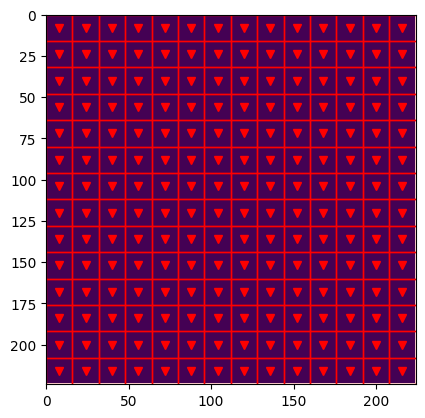

In [144]:
centers_final = grabcutextractcenters("imagem_preta.png")

print(len(centers_final))

visualize_patch_centers(imagem_preta, centers_final, (16, 16))

### Fazendo Metodo com Stride e Randomico

In [ ]:
path_img = "../../data/base_recortada/Negative for intraepithelial lesion/534.png"
im = cv2.imread(path_img)
ir = cv2.resize(im, (224, 224))
ir = cv2.cvtColor(ir, cv2.COLOR_BGR2RGB)

centers_final = grabcutextractcenters(path_img)

print(len(centers_final))

visualize_patch_centers(ir, centers_final, (16, 16))

Quantidade de patches da imagem: 196
196


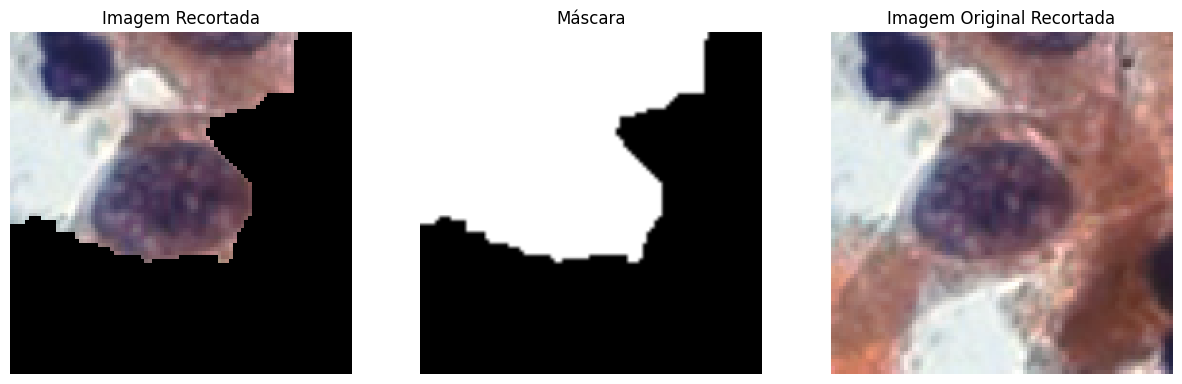

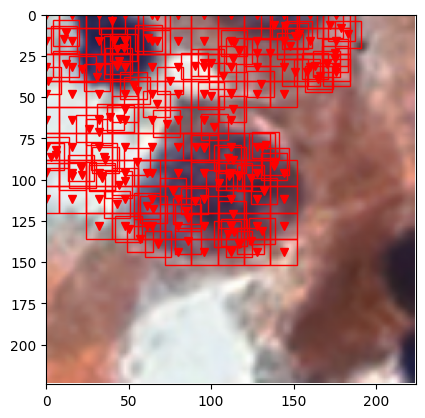

In [20]:
path_img = "../../data/base_recortada/ASC-H/10.png"
im = cv2.imread(path_img)
ir = cv2.resize(im, (224, 224))
ir = cv2.cvtColor(ir, cv2.COLOR_BGR2RGB)

centers_final = grabcutextractcenters(path_img, stride=16)

print(len(centers_final))

visualize_patch_centers(ir, centers_final, (16, 16))